In [10]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import pickle
from upsetplot import plot
from upsetplot import from_memberships
import json
import itertools

## Gene sets

In [78]:
gene_sets = ['unstrat', 'pe', 'ese', 'mse', 'early', 'late']

gene_set_dict = {}
for gs in gene_sets:
    df= pd.read_csv('../gene_sets/{}.csv'.format(gs), header=0)
    temp_set = []
    for index,row in df.iterrows():
        if (row['logFC (Control/Disease)'] > 1.1 and row['adj.P.Val'] < 0.05):
            temp_set.append(row['gene_symbol'])
    gene_set_dict[gs] = temp_set



filehandler = open("../data/gene_sets.dict","wb")
pickle.dump(gene_set_dict,filehandler)



In [81]:
filehandler = open("../data/gene_sets.dict","rb")
gene_set_dict = pickle.load(filehandler)

for key in gene_set_dict:
    print (key)
    print (len(gene_set_dict[key]))

unstrat
730
pe
1396
ese
249
mse
750
early
1169
late
603


## OG dataset

In [165]:
acc = 'GSE51981'
data = pd.read_csv('../data/{}_data.txt'.format(acc), header=0, delimiter='\t')
id_map = pd.read_csv('../data/{}_id_map.txt'.format(acc), header=0, delimiter='\t')
for index,row in id_map.iterrows():
    row['Gene Symbol'] = str(row['Gene Symbol']).split('///')[0].strip()

data = data.assign(ID_REF=id_map['Gene Symbol'])

cols = data.columns
phen_list = []
phen = pd.read_csv('../data/{}_metadata.txt'.format(acc), header=0, delimiter='\t')
sample_phen = {}
for sample in cols:
    if ('GSM' in sample):
        sample_phen[sample] = phen[sample][0]
        phen_list.append(phen[sample][0])


/var/folders/hm/d3mf7x5d0ks7hd20j03cl94w0000gq/T/ipykernel_59879/2437180610.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  id_map = pd.read_csv('../data/{}_id_map.txt'.format(acc), header=0, delimiter='\t')


unstratified

In [166]:
phen_list = []
for sample in cols:
    if ('GSM' in sample):
        phen_list.append(phen[sample][2])

gs_res = gp.gsea(data=data, 
                 gene_sets=gene_set_dict, # or enrichr library names
                 cls= phen_list, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100, # reduce number to speed up test
                 outdir='../gsea_output/unstrat/{}/'.format(acc),  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7, max_size=1396)


2023-05-24 11:34:14,025 [WARNING] Dropping duplicated gene names, only keep the first values


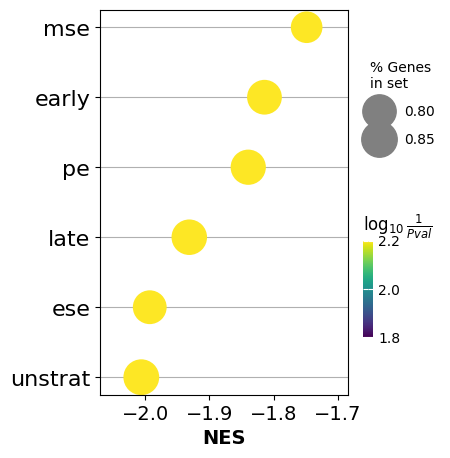

In [167]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

early stage

In [168]:
data_early = data.copy(deep=True)
phen_list_early = []
drop_samples_early = []
for sample in cols:
    if ('GSM' in sample):
        if (phen[sample][0] == 'Endometriosis_Minimal/Mild'):
            phen_list_early.append(phen[sample][0])
        elif ((phen[sample][0] == 'Non-Endometriosis_No Uterine Pelvic Pathology') or (phen[sample][0] == 'Non-Endometriosis_Uterine Pelvic Pathology')):
            phen_list_early.append('Control')
        else:
            drop_samples_early.append(sample)
data_early = data_early.drop(columns=drop_samples_early)

gs_res = gp.gsea(data=data_early, 
                 gene_sets=gene_set_dict, # or enrichr library names
                 cls= phen_list_early, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=50, # reduce number to speed up test
                 outdir='../gsea_output/early/{}/'.format(acc),  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7, max_size=1396)






2023-05-24 11:34:40,390 [WARNING] Dropping duplicated gene names, only keep the first values


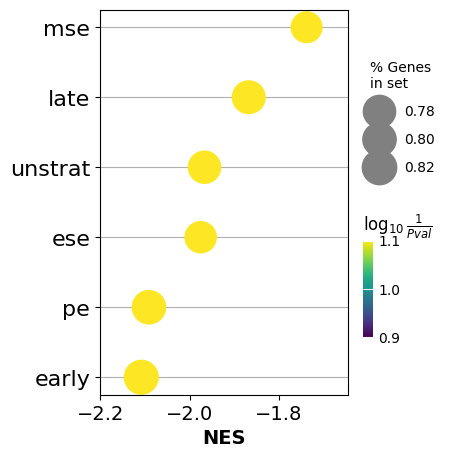

In [169]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

late stage

In [170]:
data_late = data.copy(deep=True)
phen_list_late = []
drop_samples_late = []
for sample in cols:
    if ('GSM' in sample):
        if (phen[sample][0] == 'Endometriosis_Moderate/Severe'):
            phen_list_late.append(phen[sample][0])
        elif ((phen[sample][0] == 'Non-Endometriosis_No Uterine Pelvic Pathology') or (phen[sample][0] == 'Non-Endometriosis_Uterine Pelvic Pathology')):
            phen_list_late.append('Control')
        else:
            drop_samples_late.append(sample)
data_late = data_late.drop(columns=drop_samples_late)

gs_res = gp.gsea(data=data_late, 
                 gene_sets=gene_set_dict, # or enrichr library names
                 cls= phen_list_late, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=50, # reduce number to speed up test
                 outdir='../gsea_output/late/{}/'.format(acc),  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7, max_size=1396)

2023-05-24 11:35:02,698 [WARNING] Dropping duplicated gene names, only keep the first values


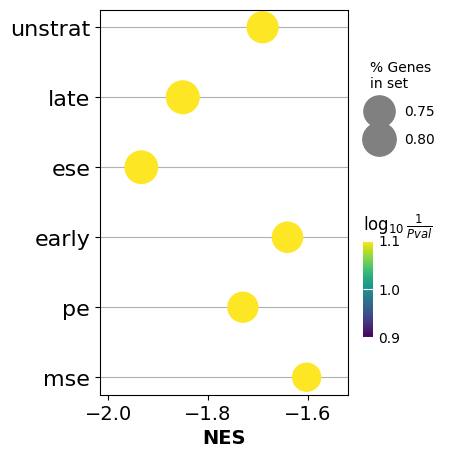

In [171]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

## New dataset

In [203]:
def run_gsea(dat, cls_list, strat, acc):
    gs_res = gp.gsea(data=dat, 
                 gene_sets=gene_set_dict, # or enrichr library names
                 cls= cls_list, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=50, # reduce number to speed up test
                 outdir='../gsea_output/{}/{}/'.format(strat, acc),  # do not write output to disk
                 method='ratio_of_classes',
                 threads=4, seed= 7, max_size=1260, verbose=False)
    terms = gs_res.res2d.Term
    print (terms)
    for i in range(0, len(terms)):
        gseaplot(gs_res.ranking, term=terms[i], **gs_res.results[terms[i]], ofname='../gsea_output/{}/{}/gsea/{}.pdf'.format(strat, acc,terms[i]))
        genes = gs_res.res2d.Lead_genes[i].split(";")
        ax = heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4), ofname='../gsea_output/{}/{}/gsea/{}.heatmap.pdf'.format(strat,acc,terms[i]))
    
    ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='{}'.format(strat),
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1, 
             ofname = '../gsea_output/{}/{}/gsea/dotplot.pdf'.format(strat,acc))


In [196]:
acc = 'GSE141549'
data = pd.read_csv('../data/{}_data.txt'.format(acc), header=0, delimiter='\t')
data = data.astype({'Gene_symbol':str})
data = data.fillna(value =0)

cols = data.columns
phen = pd.read_csv('../data/{}_metadata.txt'.format(acc), header=0, delimiter='\t')

data_gene = set(data['Gene_symbol'].tolist())
gs_count = {}
for gs in gene_set_dict:
    gs_count[gs] = 0
    for gene in gene_set_dict[gs]:
        if (gene in data_gene):
            gs_count[gs] += 1

print (gs_count)



{'unstrat': 647, 'pe': 1260, 'ese': 220, 'mse': 661, 'early': 1048, 'late': 535}


# New - unstratified

In [204]:
data_unstrat = data.copy(deep=True)
phen_list_unstrat = []
drop_samples_unstrat = []
tot_sample = []
for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_unstrat.append('Control')
        elif ('disease' in phen[sample][4]):
            phen_list_unstrat.append('Disease')
        else:
            drop_samples_unstrat.append(sample)
data_unstrat = data_unstrat.drop(columns=drop_samples_unstrat)

run_gsea(data_unstrat, phen_list_unstrat, 'unstrat', acc)


2023-05-24 12:08:18,410 [WARNING] Dropping duplicated gene names, only keep the first values


0        ese
1       late
2      early
3         pe
4    unstrat
5        mse
Name: Term, dtype: object


# New - early

In [205]:
data_early = data.copy(deep=True)
phen_list_early = []
drop_samples_early = []

for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_early.append('Control')
        elif ('disease' in phen[sample][4] and ('1' in phen[sample][4] or '2' in phen[sample][4])  ):
            phen_list_early.append('Early disease')
        else:
            drop_samples_early.append(sample)

print (len(phen_list_early))
data_early = data_early.drop(columns=drop_samples_early)


run_gsea(data_early, phen_list_early, 'early', acc)


2023-05-24 12:08:34,728 [WARNING] Dropping duplicated gene names, only keep the first values


151
0        ese
1       late
2    unstrat
3        mse
4         pe
5      early
Name: Term, dtype: object


# New - late

In [206]:
data_late = data.copy(deep=True)
phen_list_late = []
drop_samples_late = []

for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_late.append('Control')
        elif ('disease' in phen[sample][4] and ('3' in phen[sample][4] or '4' in phen[sample][4])  ):
            phen_list_late.append('Late disease')
        else:
            drop_samples_late.append(sample)

print (len(phen_list_late))
data_late = data_late.drop(columns=drop_samples_late)


run_gsea(data_late, phen_list_late, 'late', acc)

2023-05-24 12:09:13,028 [WARNING] Dropping duplicated gene names, only keep the first values


316
0        ese
1      early
2         pe
3        mse
4       late
5    unstrat
Name: Term, dtype: object


# NEW - FIRST

In [208]:
data_first = data.copy(deep=True)
phen_list_first = []
drop_samples_first = []

for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_first.append('Control')
        elif ('disease' in phen[sample][4] and ('1' in phen[sample][4])  ):
            phen_list_first.append('First stage')
        else:
            drop_samples_first.append(sample)

print (len(phen_list_first))
data_first = data_first.drop(columns=drop_samples_first)


run_gsea(data_first, phen_list_first, 'first', acc)

2023-05-24 12:12:30,277 [WARNING] Dropping duplicated gene names, only keep the first values


108
0        ese
1       late
2    unstrat
3        mse
4         pe
5      early
Name: Term, dtype: object


# New - Second

In [209]:
data_second = data.copy(deep=True)
phen_list_second = []
drop_samples_second = []

for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_second.append('Control')
        elif ('disease' in phen[sample][4] and ('2' in phen[sample][4])  ):
            phen_list_second.append('Second stage')
        else:
            drop_samples_second.append(sample)

print (len(phen_list_second))
data_second = data_second.drop(columns=drop_samples_second)


run_gsea(data_second, phen_list_second, 'second', acc)

2023-05-24 12:14:05,088 [WARNING] Dropping duplicated gene names, only keep the first values


109
0        ese
1       late
2    unstrat
3         pe
4      early
5        mse
Name: Term, dtype: object


# New - third

In [210]:
data_third = data.copy(deep=True)
phen_list_third = []
drop_samples_third = []

for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_third.append('Control')
        elif ('disease' in phen[sample][4] and ('3' in phen[sample][4])  ):
            phen_list_third.append('Third stage')
        else:
            drop_samples_third.append(sample)

print (len(phen_list_third))
data_third = data_third.drop(columns=drop_samples_third)


run_gsea(data_third, phen_list_third, 'third', acc)

2023-05-24 12:15:17,565 [WARNING] Dropping duplicated gene names, only keep the first values


146
0        ese
1       late
2    unstrat
3        mse
4         pe
5      early
Name: Term, dtype: object


# New - Fourth

In [211]:
data_fourth = data.copy(deep=True)
phen_list_fourth = []
drop_samples_fourth = []

for sample in cols:
    if ('SAMPLE' in sample):
        if ('disease' in phen[sample][4] and 'Healthy' in phen[sample][4]):
            phen_list_fourth.append('Control')
        elif ('disease' in phen[sample][4] and ('4' in phen[sample][4])  ):
            phen_list_fourth.append('Fourth stage')
        else:
            drop_samples_fourth.append(sample)

print (len(phen_list_fourth))
data_fourth = data_fourth.drop(columns=drop_samples_fourth)


run_gsea(data_fourth, phen_list_fourth, 'fourth', acc)

2023-05-24 12:16:17,417 [WARNING] Dropping duplicated gene names, only keep the first values


236
0        ese
1      early
2         pe
3        mse
4    unstrat
5       late
Name: Term, dtype: object


646
206
[['first'], ['second'], ['third'], ['fourth'], ['first', 'second'], ['first', 'third'], ['first', 'fourth'], ['second', 'third'], ['second', 'fourth'], ['third', 'fourth'], ['first', 'second', 'third'], ['first', 'second', 'fourth'], ['first', 'third', 'fourth'], ['second', 'third', 'fourth'], ['first', 'second', 'third', 'fourth']]
[1169, 730, 603, 249, 685, 535, 201, 577, 207, 206, 535, 192, 186, 201, 186]


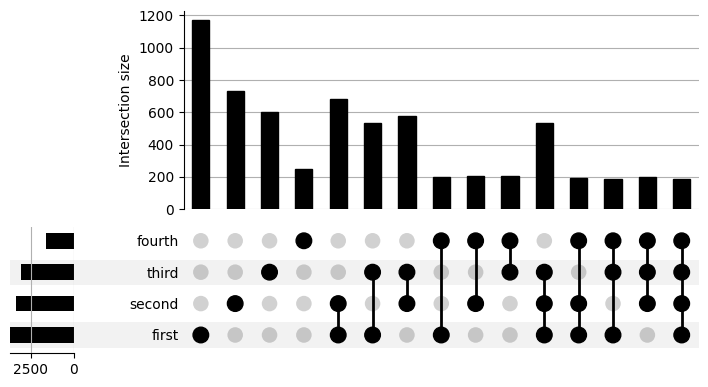

In [21]:
filehandler = open("../data/gene_sets.dict","rb")
gene_set = pickle.load(filehandler)
gene_set_temp = {'first': set(gene_set['early']),
                 'second': set(gene_set['unstrat']),
                 'third': set(gene_set['late']),
                 'fourth': set(gene_set['ese'])}

        
strats = ['first', 'second', 'third', 'fourth']
perm_strat = []
for i in range(0, len(strats)):
    combs = list(itertools.combinations(strats, i+1))

    for p in combs:
        perm_strat.append(list(p))
data = []
for perm in perm_strat:
    temp_list = []
    for p in perm:
        temp_list.append(gene_set_temp[p])
    
    data.append(len(set.intersection(*temp_list)))
print (len(set.union(gene_set_temp['third'], gene_set_temp['fourth'])))
print ((len(set.intersection(gene_set_temp['third'], gene_set_temp['fourth']))))
print (perm_strat)
print (data)
example = from_memberships(perm_strat, data=data)
plot(example) 
#plt.savefig('{}/figs/drug_set_{}.png'.format(acc, acc))
plt.show()